In [1]:
import cv2 
print(cv2.__version__)

4.7.0


In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-03-24 17:20:23--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.2’

yolov3.weights.2    100%[===================>] 236.52M  22.8MB/s    in 11s     

2023-03-24 17:20:35 (21.4 MB/s) - ‘yolov3.weights.2’ saved [248007048/248007048]



In [4]:
!wget /content/darknet/cfg/yolov3.cfg

/content/darknet/cfg/yolov3.cfg: Scheme missing.


In [5]:
weights_path = "/content/yolov3.weights"
config_path = "/content/darknet/cfg/yolov3.cfg"
classes_path = "/content/darknet/data/coco.names"

# Loading YOLO 
net = cv2.dnn.readNet(weights_path,config_path)
classes = [line.rstrip("\n") for line in open(classes_path,"r")]

In [6]:
print(f"The {len(classes)} classes of yolov3: {classes}")

The 80 classes of yolov3: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [7]:
# Lets deepdive into model 
# Getting Layer names: list of the names of all the layers in the network.
layer_names = net.getLayerNames()
# Getting outputLayers
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0,255,size=(len(classes),3))

In [8]:
print(layer_names) 
print(net.getUnconnectedOutLayers())

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [42]:
# We may have lot of bounding boxes for predicting things, but we need one with high confidence, so lets use NMS
# Non-Maximum Supression: supressing the values other than maximum one.

In [10]:
import os 
from os import listdir 
images_path = '/content/drive/MyDrive/yolov3_images/'
file_names = listdir(images_path)
# Reading and processsing on images!
images_arr = []
lst = [images_path+file for file in file_names] # to read at path 
print(lst)
for img in lst:
  print('Image Name: ',img)
  img = cv2.imread(img,1) 
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
  resized = cv2.resize(img,None,fx=0.4,fy=0.4) 
  height1,width1,channels1 = resized.shape 

  ## Lets detect objects 
  blob = cv2.dnn.blobFromImage(resized,0.00392,(416,416),(0,0,0),True,crop=False)
  net.setInput(blob)
  # Sending image to model
  outs = net.forward(output_layers) 
  

  # Lets iterate through outs
  class_ids = []
  confidences = []
  boxes = []

  for out in outs:
    for detection in out:
      scores = detection[5:] # As the first 4 elements of list are co-ordinates are bbox, we dont touch them.
      class_id = np.argmax(scores) # Gets the index of highest value of list
      confidence = scores[class_id]  # Gets the confidence at the obtained class_id 
      if confidence > 0.5:# Considering bbox only if confidence of prediction is greater than 50%.
        center_x = int(detection[0]*width1)
        center_y = int(detection[1]*height1)
        bbox_w = int(detection[2]*width1)
        bbox_h = int(detection[3]*height1) 

        # Converting to absolute values such that we can draw bboxes using opencv rectangle
        x = int(center_x - bbox_w/2)
        y = int(center_y - bbox_h/2) 

        boxes.append([x,y,bbox_w,bbox_h])
        confidences.append(float(confidence))
        class_ids.append(class_id) 

  indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.5,0.4)
  font = cv2.FONT_HERSHEY_PLAIN 
  labels = []
  for i in range(len(boxes)):
    if i in indexes:
      x,y,w,h = boxes[i] 
      label = str(classes[class_ids[i]])
      color = colors[i] 
      labels.append(label)
      cv2.rectangle(resized,(x,y),(x+w,y+h),color,2) # We are adding width and height in second co-ordinates becoz 
      ## The first co-ordinates (x,y) are (top,left) point on an image & we are adding this point to width & height of bbox 
      ## to get the (bottom,right) point which will be an end to bbox, bottom = top + bbox_height, right = left + bbox_width 
      print(f"predicted as: {label}")
      cv2.putText(resized,label,(x,y+30),font,4,(255,255,255),3)
  images_arr.append((resized,labels)) 

['/content/drive/MyDrive/yolov3_images/self.jpg', '/content/drive/MyDrive/yolov3_images/self1.jpg', '/content/drive/MyDrive/yolov3_images/self2.jpg', '/content/drive/MyDrive/yolov3_images/self3.jpg', '/content/drive/MyDrive/yolov3_images/self4.jpg']
Image Name:  /content/drive/MyDrive/yolov3_images/self.jpg
predicted as: person
predicted as: person
Image Name:  /content/drive/MyDrive/yolov3_images/self1.jpg
predicted as: tvmonitor
predicted as: pottedplant
predicted as: pottedplant
predicted as: pottedplant
predicted as: vase
predicted as: cup
Image Name:  /content/drive/MyDrive/yolov3_images/self2.jpg
predicted as: tvmonitor
Image Name:  /content/drive/MyDrive/yolov3_images/self3.jpg
predicted as: dog
Image Name:  /content/drive/MyDrive/yolov3_images/self4.jpg


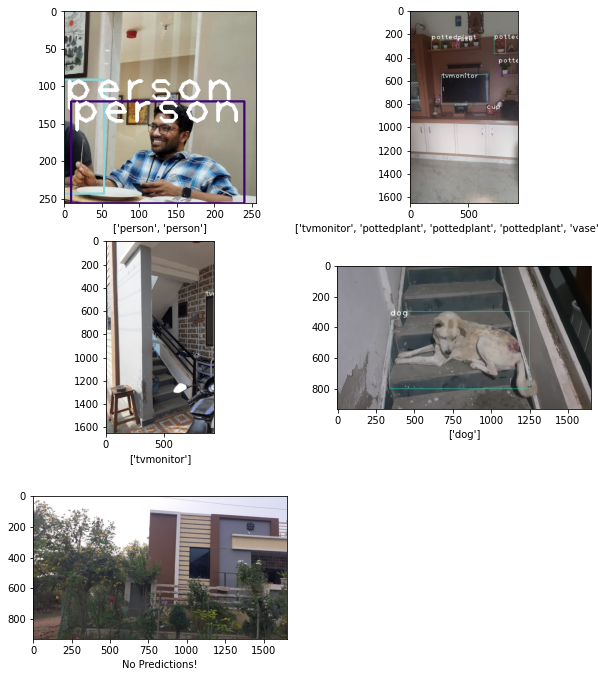

In [12]:
fig = plt.figure(figsize=(10,12))
for i in range(1,1+len(images_arr)): 
  plt.subplot(3,2,i) 
  plt.imshow(images_arr[i-1][0])
  if images_arr[i-1][1]:
    plt.xlabel(images_arr[i-1][1])
  else:
    plt.xlabel('No Predictions!')
  # plt.axis('off')

In [13]:
print("Done! 4 out 5 got predicted where 1 of them has misprediction and 1 one of image is non-predicted")

Done! 4 out 5 got predicted where 1 of them has misprediction and 1 one of image is non-predicted
